In [16]:
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns

In [1]:
!pip install tensorflowjs


INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 42.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin

In [ ]:
drive.flush_and_unmount()

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Define paths and parameters
base_path = '/content/drive/My Drive/Dataset'
BATCH_SIZE = 32
IMAGE_SIZE = 224  # Adjusted to 224 for compatibility with pre-trained models if needed
CHANNELS = 3
EPOCHS = 10
INITIAL_LR = 0.001

In [10]:
BATCH_SIZE = 32
IMAGE_SIZE = 244
CHANNELS=3
EPOCHS=10
INITIAL_LR = 0.001

Found 7038 files belonging to 8 classes.


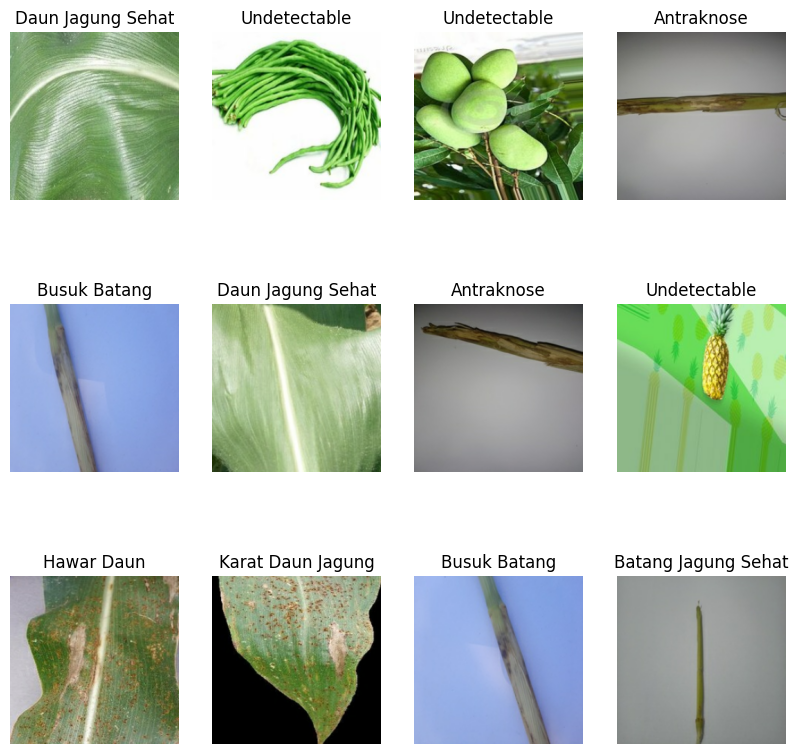

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
class_names

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [18]:
# Load dataset using ImageDataGenerator
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],
)

val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Train and Validation Generators
train_generator = train_data_gen.flow_from_directory(
    base_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = val_data_gen.flow_from_directory(
    base_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 5634 images belonging to 8 classes.
Found 1404 images belonging to 8 classes.


In [19]:
# Build CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr * 0.5
    return lr

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 456,264 (1.74 MB)

 Trainable params: 456,264 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Callbacks
lr_callback = LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, lr_callback]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 4332s 24s/step - accuracy: 0.4311 - loss: 1.4656 - val_accuracy: 0.8285 - val_loss: 0.5812 - learning_rate: 0.0010
Epoch 2/10
  1/176 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.8125 - loss: 0.4346

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.8125 - loss: 0.4346 - val_accuracy: 0.7500 - val_loss: 1.4004 - learning_rate: 0.0010
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 113s 620ms/step - accuracy: 0.8275 - loss: 0.4981 - val_accuracy: 0.8634 - val_loss: 0.3750 - learning_rate: 0.0010
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.8438 - loss: 0.2055 - val_accuracy: 0.8571 - val_loss: 0.2033 - learning_rate: 0.0010
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 112s 617ms/step - accuracy: 0.8824 - loss: 0.3445 - val_accuracy: 0.8910 - val_loss: 0.2413 - learning_rate: 0.0010
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9375 - loss: 0.2347 - val_accuracy: 0.8571 - val_loss: 0.3256 - learning_rate: 0.0010
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 112s 617ms/step - accuracy: 0.8852 - loss: 0.3239 - val_accuracy: 0.9201 - val_loss: 0.2000 - learning_rate: 0.0010
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8438 - loss: 0

In [23]:
# Data Augmentation untuk data uji
test_data_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_data_gen.flow_from_directory(
    base_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Jangan shuffle untuk evaluasi
)


Found 7038 images belonging to 8 classes.


In [24]:
# Evaluasi model pada data uji
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


219/219 ━━━━━━━━━━━━━━━━━━━━ 33s 150ms/step - accuracy: 0.9541 - loss: 0.0982
Test Loss: 0.16163694858551025
Test Accuracy: 0.9257990717887878


In [25]:
!mkdir -p saved_model


In [26]:
model.export('saved_model/my_model')

Saved artifact at 'saved_model/my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  138947032005824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138949902237216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138947036535040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138947036536272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138947036532928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138947036196256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138947036196432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138947036192384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138947036195904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138947036196784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1389470361

In [27]:
print("Jumlah data uji:", test_generator.samples)


Jumlah data uji: 7038


220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 163ms/step


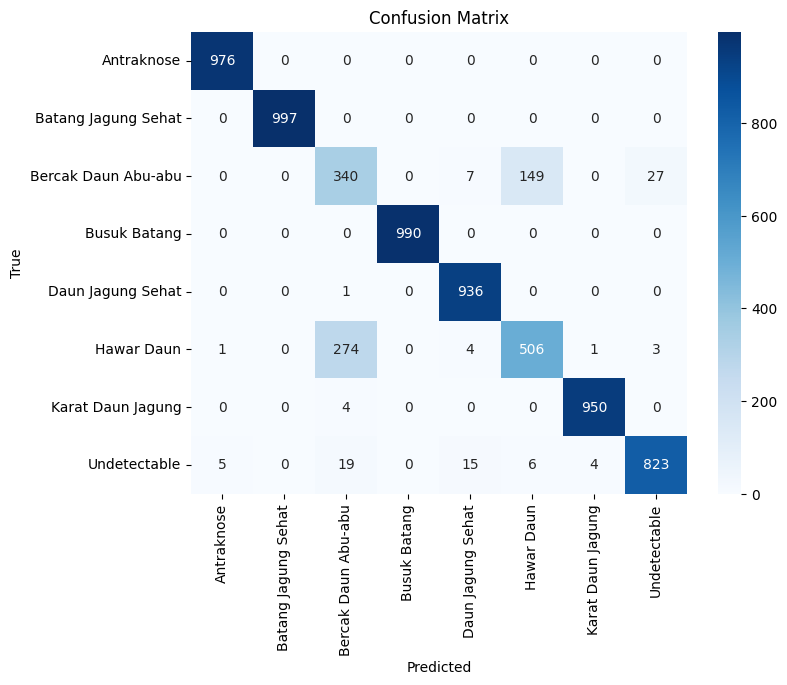

In [28]:
# Dapatkan prediksi model untuk data uji
predictions = model.predict(test_generator, steps=int(np.ceil(test_generator.samples / BATCH_SIZE)))
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Pastikan true_classes dan predicted_classes memiliki panjang yang sama
assert len(true_classes) == len(predicted_classes), f"Mismatch: {len(true_classes)} != {len(predicted_classes)}"

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Visualisasi confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [29]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print(report)


                     precision    recall  f1-score   support

         Antraknose       0.99      1.00      1.00       976
Batang Jagung Sehat       1.00      1.00      1.00       997
Bercak Daun Abu-abu       0.53      0.65      0.59       523
       Busuk Batang       1.00      1.00      1.00       990
  Daun Jagung Sehat       0.97      1.00      0.99       937
         Hawar Daun       0.77      0.64      0.70       789
  Karat Daun Jagung       0.99      1.00      1.00       954
       Undetectable       0.96      0.94      0.95       872

           accuracy                           0.93      7038
          macro avg       0.90      0.90      0.90      7038
       weighted avg       0.93      0.93      0.93      7038



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


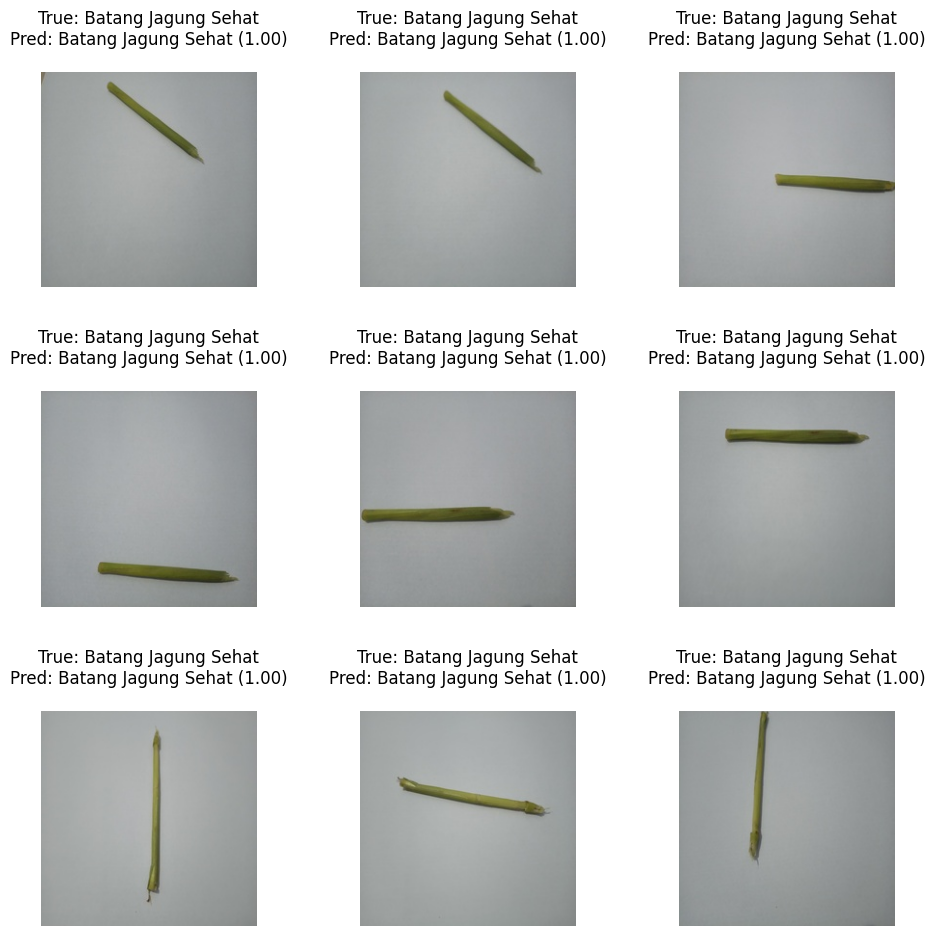

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Visualisasi beberapa prediksi
plt.figure(figsize=(10, 10))

# Ambil 9 gambar acak untuk diuji
for i in range(9):
    img, label = next(test_generator)  # Menggunakan next() untuk mengambil batch

    # Ambil gambar acak dari batch
    random_index = np.random.randint(0, len(img))
    selected_img = img[random_index]
    selected_label = label[random_index]

    # Prediksi untuk gambar yang dipilih secara acak
    prediction = model.predict(np.expand_dims(selected_img, axis=0))  # Perlu expand_dims untuk batch dim
    predicted_prob = np.max(prediction[0])  # Confidence untuk kelas prediksi
    predicted_label = class_names[np.argmax(prediction[0])]  # Ambil prediksi kelas

    # Akses label yang sebenarnya
    true_label = class_names[np.argmax(selected_label)]  # Ambil label dari satu-hot encoding

    # Tampilkan gambar dan label
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(selected_img)  # Tampilkan gambar yang dipilih
    plt.title(f"True: {true_label}\nPred: {predicted_label} ({predicted_prob:.2f})", pad=20)  # Tambah confidence
    plt.axis('off')

# Menyesuaikan layout agar tidak ada tumpang tindih
plt.tight_layout(pad=3.0)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


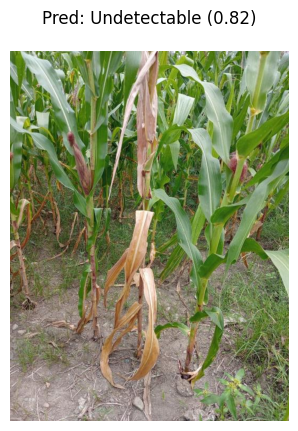

In [38]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)  # Memuat gambar dan mengubah ukuran
    img_array = img_to_array(img)  # Mengubah gambar menjadi array numpy
    img_array = np.expand_dims(img_array, axis=0)  # Menambah dimensi untuk batch
    img_array = img_array / 255.0  # Normalisasi jika perlu (misalnya, pembagian dengan 255)
    return img_array

# Path ke gambar luar dataset (misalnya, gambar baru)
image_path = "./busuk.jpg"

# Memuat dan memproses gambar
processed_image = load_and_preprocess_image(image_path)

# Prediksi dengan model
prediction = model.predict(processed_image)
predicted_prob = np.max(prediction[0])  # Confidence untuk kelas prediksi
predicted_label = class_names[np.argmax(prediction[0])]  # Ambil prediksi kelas

# Menampilkan gambar dan hasil prediksi
img = image.load_img(image_path)  # Memuat gambar asli untuk ditampilkan
plt.imshow(img)
plt.title(f"Pred: {predicted_label} ({predicted_prob:.2f})", pad=20)
plt.axis('off')
plt.show()


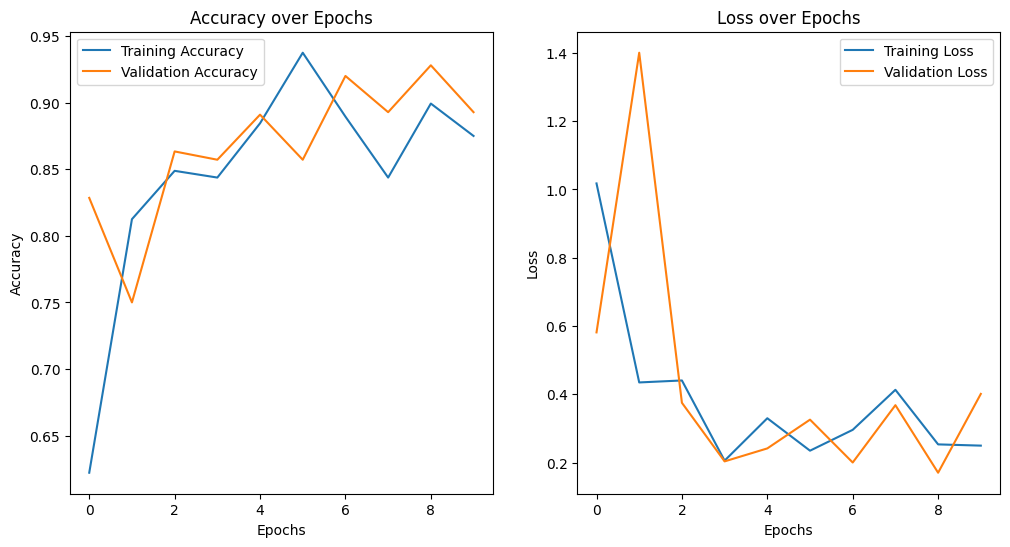

In [39]:
# Plotting training and validation accuracy/loss
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [40]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Ambil jumlah gambar yang benar (misalnya test_generator.samples)
num_samples = test_generator.samples

# Prediksi probabilitas untuk setiap kelas (multi-class)
steps = np.ceil(num_samples / BATCH_SIZE).astype(int)  # Ubah ke integer
predictions_prob = model.predict(test_generator, steps=steps)

# Ambil kelas asli
true_classes = test_generator.classes

# Hitung AUC-ROC dengan multi_class='ovr' (One-vs-Rest)
roc_auc = roc_auc_score(true_classes, predictions_prob, multi_class='ovr', average='macro')
print(f"AUC-ROC: {roc_auc}")


220/220 ━━━━━━━━━━━━━━━━━━━━ 31s 141ms/step
AUC-ROC: 0.9914662042962469


220/220 ━━━━━━━━━━━━━━━━━━━━ 31s 142ms/step


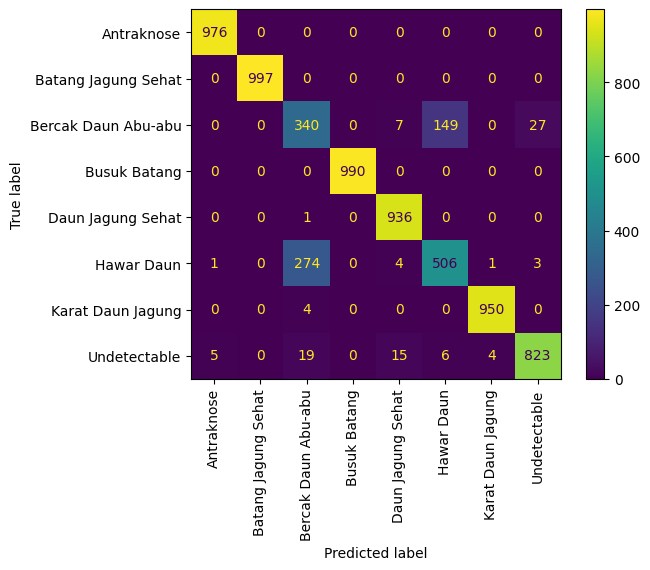

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Prediksi model
steps = int(np.ceil(test_generator.samples / BATCH_SIZE))  # Konversi ke integer
predictions = model.predict(test_generator, steps=steps)
predicted_classes = np.argmax(predictions, axis=1)

# True classes dari generator
true_classes = test_generator.classes

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation='vertical')


In [42]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model/my_model tfjs_model


2024-12-10 21:21:38.538639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733865698.559699   35546 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733865698.566387   35546 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2024-12-10 21:21:41.835038: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1733865701.835211   35546 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [43]:
# Contoh: Mengubah folder "my_folder" menjadi ZIP
!zip -r my_tfjs.zip ./tfjs_model

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/model.json (deflated 90%)
  adding: tfjs_model/group1-shard1of1.bin (deflated 8%)
